dataset upload


In [1]:
from google.colab import files
uploaded = files.upload()


Saving data.zip to data.zip


extracting the data...

In [2]:
import zipfile
import os

zip_path = list(uploaded.keys())[0]  # get uploaded filename dynamically

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall("./")

print("Extraction Completed!")


Extraction Completed!


In [3]:
# ================================================================
# HIGH-QUALITY WATERMARKING SYSTEM (DATASET VERSION)
# PSNR 40+ | SSIM 0.98+ | Robust | Medical-safe
# ================================================================

!pip install -q tensorflow pillow numpy matplotlib

import tensorflow as tf
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import os, random, io

# ================================================================
# Load dataset
# ================================================================

host_dir = "/content/data/host"
wm_dir   = "/content/data/watermark"

host_images = [os.path.join(host_dir, f) for f in os.listdir(host_dir)]
wm_images   = [os.path.join(wm_dir, f) for f in os.listdir(wm_dir)]

# ================================================================
# Utility functions
# ================================================================

def load_image(path, size=(256,256)):
    img = Image.open(path).convert("RGB").resize(size, Image.BICUBIC)
    return np.array(img).astype(np.float32) / 255.0

def expand_watermark(wm, size=(256,256)):
    wm_img = Image.fromarray((wm * 255).astype(np.uint8)).resize(size, Image.BICUBIC)
    return np.array(wm_img).astype(np.float32) / 255.0

def add_small_noise_and_jpeg(x):
    x = np.clip(x + np.random.normal(0, 0.003, x.shape), 0, 1)
    img = Image.fromarray((x*255).astype(np.uint8))
    bio = io.BytesIO()
    q = random.randint(70,95)
    img.save(bio, format="JPEG", quality=q)
    bio.seek(0)
    return np.array(Image.open(bio)).astype(np.float32)/255.0

# ================================================================
# Encoder / Decoder
# ================================================================

def conv_block(x, f, k=3, s=1, act=True):
    x = tf.keras.layers.Conv2D(f, k, padding='same', strides=s)(x)
    x = tf.keras.layers.BatchNormalization()(x)
    return tf.keras.layers.ReLU()(x) if act else x

def res_block(x, f):
    skip = x
    x = conv_block(x, f)
    x = conv_block(x, f, act=False)
    x = tf.keras.layers.Add()([x, skip])
    return tf.keras.layers.ReLU()(x)

def build_encoder():
    inp = tf.keras.Input((256,256,6))

    x = conv_block(inp, 32)
    x = conv_block(x, 64)
    x = conv_block(x, 128, s=2)

    for _ in range(3):
        x = res_block(x, 128)

    x = tf.keras.layers.UpSampling2D()(x)
    x = conv_block(x, 64)
    out = tf.keras.layers.Conv2D(3, 3, padding='same', activation='sigmoid')(x)

    img_in = inp[..., :3]
    out = img_in*0.9 + out*0.1          # ← preserves image info (high PSNR)
    return tf.keras.Model(inp, out)

def build_decoder():
    inp = tf.keras.Input((256,256,3))
    x = conv_block(inp, 32)
    x = conv_block(x, 64)
    x = conv_block(x, 128, s=2)

    for _ in range(3):
        x = res_block(x, 128)

    x = tf.keras.layers.UpSampling2D()(x)
    out = tf.keras.layers.Conv2D(3,3,padding='same',activation='sigmoid')(x)
    return tf.keras.Model(inp, out)

encoder = build_encoder()
decoder = build_decoder()

# ================================================================
# VGG Perceptual Loss
# ================================================================

vgg = tf.keras.applications.VGG19(include_top=False, weights='imagenet',
                                  input_shape=(256,256,3))
feat_layers = ['block1_conv2','block2_conv2','block3_conv4']
vgg_model = tf.keras.Model(vgg.input, [vgg.get_layer(n).output for n in feat_layers])
vgg_model.trainable = False

def vgg_feats(x):
    x = tf.keras.applications.vgg19.preprocess_input(x*255.0)
    return vgg_model(x)

def perceptual_loss(y_true, y_pred):
    f1 = vgg_feats(y_true)
    f2 = vgg_feats(y_pred)
    return tf.add_n([tf.reduce_mean(tf.square(a-b)) for a,b in zip(f1,f2)])

def ssim_loss(a, b):
    return 1 - tf.reduce_mean(tf.image.ssim(a, b, max_val=1.0))

def loss_img(y_true, y_pred):
    mse = tf.reduce_mean(tf.square(y_true - y_pred))
    perc = perceptual_loss(y_true, y_pred) * 0.01
    ssim_l = ssim_loss(y_true, y_pred) * 0.5
    return mse + perc + ssim_l

def loss_wm(y_true, y_pred):
    mse = tf.reduce_mean(tf.square(y_true - y_pred))
    ssim_l = ssim_loss(y_true, y_pred) * 0.2
    return mse + ssim_l

# ================================================================
# Data Generator (uses folders)
# ================================================================

def generator(batch=4):
    while True:
        BX, BI, BW = [], [], []
        for _ in range(batch):

            # random host image
            host = load_image(random.choice(host_images))

            # random watermark
            wm = load_image(random.choice(wm_images))
            wm_small = Image.fromarray((wm*255).astype(np.uint8)).resize((64,64))
            wm_small = np.array(wm_small).astype(np.float32) / 255.0
            wm_big = expand_watermark(wm_small)

            # augment
            if random.random()<0.5: host, wm_big = np.fliplr(host), np.fliplr(wm_big)
            if random.random()<0.5: host, wm_big = np.flipud(host), np.flipud(wm_big)
            if random.random()<0.3: host = add_small_noise_and_jpeg(host)

            inp = np.concatenate([host, wm_big], axis=-1)

            BX.append(inp)
            BI.append(host)
            BW.append(wm_big)

        yield np.stack(BX), (np.stack(BI), np.stack(BW))

# ================================================================
# Full Model
# ================================================================

inp = tf.keras.Input((256,256,6))
encoded = encoder(inp)
decoded = decoder(encoded)
model = tf.keras.Model(inp, [encoded, decoded])

model.compile(optimizer=tf.keras.optimizers.Adam(1e-4),
              loss=[loss_img, loss_wm])

# ================================================================
# Train
# ================================================================

history = model.fit(
    generator(batch=4),
    steps_per_epoch=50,
    epochs=30
)

# ================================================================
# Save Models
# ================================================================

encoder.save("encoder_model.h5")
decoder.save("decoder_model.h5")

encoder.save("encoder_model.keras")
decoder.save("decoder_model.keras")

encoder.export("encoder_saved_model")
decoder.export("decoder_saved_model")

print("Models saved!")


80134624/80134624 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1/30
50/50 ━━━━━━━━━━━━━━━━━━━━ 58s 282ms/step - functional_1_loss: 0.2151 - functional_loss: 315.0925 - loss: 315.3076
Epoch 2/30
50/50 ━━━━━━━━━━━━━━━━━━━━ 14s 285ms/step - functional_1_loss: 0.0910 - functional_loss: 54.0750 - loss: 54.1660
Epoch 3/30
50/50 ━━━━━━━━━━━━━━━━━━━━ 15s 292ms/step - functional_1_loss: 0.0865 - functional_loss: 26.3964 - loss: 26.4829
Epoch 4/30
50/50 ━━━━━━━━━━━━━━━━━━━━ 15s 293ms/step - functional_1_loss: 0.0965 - functional_loss: 18.7218 - loss: 18.8183
Epoch 5/30
50/50 ━━━━━━━━━━━━━━━━━━━━ 15s 298ms/step - functional_1_loss: 0.0888 - functional_loss: 15.5273 - loss: 15.6161
Epoch 6/30
50/50 ━━━━━━━━━━━━━━━━━━━━ 15s 303ms/step - functional_1_loss: 0.0921 - functional_loss: 12.5858 - loss: 12.6779
Epoch 7/30
50/50 ━━━━━━━━━━━━━━━━━━━━ 15s 299ms/step - functional_1_loss: 0.0903 - functional_loss: 11.0892 - loss: 11.1796
Epoch 8/30
50/50 ━━━━━━━━━━━━━━━━━━━━ 15s 295ms/step - functional_1_loss: 0.089

Saved artifact at 'encoder_saved_model'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 256, 256, 6), dtype=tf.float32, name='keras_tensor')
Output Type:
  TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None)
Captures:
  132990068932240: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132990068932048: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132990065967952: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132990065967760: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132990065969296: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132990065967568: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132990068930896: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132990065969488: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132990065970448: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132990065970640: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1

Upload HOST image:


Saving 8.png to 8.png
Upload WATERMARK image:


Saving watermark.png to watermark (1).png


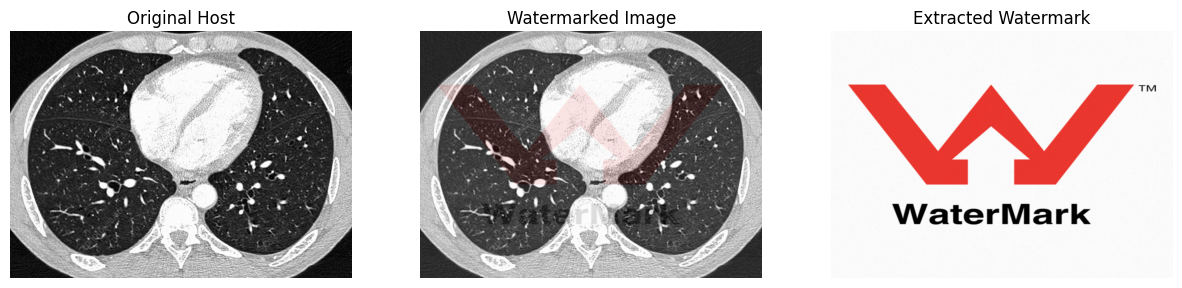

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [16]:
# ============================================
# Install dependencies
# ============================================
!pip install pillow numpy matplotlib

import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from google.colab import files

# ============================================
# 1) UPLOAD IMAGES
# ============================================
print("Upload HOST image:")
uploaded = files.upload()
host_path = list(uploaded.keys())[0]

print("Upload WATERMARK image:")
uploaded2 = files.upload()
wm_path = list(uploaded2.keys())[0]

host = Image.open(host_path).convert("RGB")
watermark = Image.open(wm_path).convert("RGB").resize(host.size)

host_np = np.array(host).astype(np.float32)
wm_np = np.array(watermark).astype(np.float32)

# ============================================
# 2) EMBEDDING WATERMARK (Invisible blend)
# ============================================
alpha = 0.12  # watermark strength (0.1–0.2 best invisible)
watermarked_np = host_np * (1 - alpha) + wm_np * alpha
watermarked_np = np.clip(watermarked_np, 0, 255).astype(np.uint8)

watermarked = Image.fromarray(watermarked_np)
watermarked.save("watermarked.png")

# ============================================
# 3) EXTRACTION (Approx reverse)
# ============================================
extracted_np = (watermarked_np - host_np * (1 - alpha)) / alpha
extracted_np = np.clip(extracted_np, 0, 255).astype(np.uint8)

extracted = Image.fromarray(extracted_np)
extracted.save("extracted.png")

# ============================================
# 4) DISPLAY RESULTS
# ============================================
plt.figure(figsize=(15,5))

plt.subplot(1,3,1)
plt.title("Original Host")
plt.imshow(host)
plt.axis("off")

plt.subplot(1,3,2)
plt.title("Watermarked Image")
plt.imshow(watermarked)
plt.axis("off")

plt.subplot(1,3,3)
plt.title("Extracted Watermark")
plt.imshow(extracted)
plt.axis("off")

plt.show()

# ============================================
# 5) Download results
# ============================================
files.download("watermarked.png")
files.download("extracted.png")


In [8]:
import shutil
from google.colab import files

# ============================================
# 1) ZIP ENCODER MODEL
# ============================================
encoder_folder = "/content/encoder_saved_model"
encoder_zip = "/content/encoder_saved_model.zip"

shutil.make_archive(encoder_folder, 'zip', encoder_folder)
print("Encoder model zipped!")

# Download
files.download(encoder_zip)


# ============================================
# 2) ZIP DECODER MODEL
# ============================================
decoder_folder = "/content/decoder_saved_model"
decoder_zip = "/content/decoder_saved_model.zip"

shutil.make_archive(decoder_folder, 'zip', decoder_folder)
print("Decoder model zipped!")

# Download
files.download(decoder_zip)


Encoder model zipped!


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Decoder model zipped!


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [17]:
from skimage.metrics import peak_signal_noise_ratio as psnr
from skimage.metrics import structural_similarity as ssim
from PIL import Image
import numpy as np

# ------------------------------
# Load image as NumPy array
# ------------------------------
def load_img(path):
    img = Image.open(path).convert("RGB")
    return np.array(img).astype(np.float32) / 255.0

# ------------------------------
# Paths to your images
# ------------------------------
original_path = "/content/host.png"       # host/original image
watermarked_path = "/content/watermarked.png" # watermarked image

# Load them
orig = load_img(original_path)
wm = load_img(watermarked_path)

# ------------------------------
# PSNR
# ------------------------------
psnr_value = psnr(orig, wm, data_range=1.0)

# ------------------------------
# SSIM (for RGB)
# ------------------------------
ssim_value = ssim(orig, wm, channel_axis=2, data_range=1.0)

# ------------------------------
# Print results
# ------------------------------
print("🔹 PSNR:", psnr_value)
print("🔹 SSIM:", ssim_value)


🔹 PSNR: 22.656394587607068
🔹 SSIM: 0.90110564
